In [7]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier,RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.metrics import classification_report, roc_auc_score, roc_curve



In [8]:
df = pd.read_csv('data/processed_loan_data.csv')

In [ ]:
loanstatus_0 = df[df["default_flag"]==0]
loanstatus_1 = df[df["default_flag"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=55000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=55000)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()


Current shape of dataset : (11000, 26)


,loan_amnt,term,int_rate,installment,grade,sub_grade,purpose,annual_inc,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,tot_cur_bal,total_rev_hi_lim,funded_amnt,default_flag
0,9950.0,36,14.33,341.67,3,12,4,28800.0,8.0,1,...,5.0,0.0,8042.0,50.6,11.0,0.0,22148.0,15900.0,9950.0,1
1,4500.0,36,18.99,164.93,5,21,9,79000.0,10.0,5,...,9.0,0.0,5763.0,52.4,27.0,0.0,36582.0,11000.0,4500.0,0
2,35000.0,60,17.86,886.11,4,20,2,91000.0,2.0,5,...,13.0,0.0,22999.0,57.5,24.0,0.0,56596.0,40000.0,35000.0,1
3,13500.0,60,19.42,353.33,5,23,2,36996.0,4.0,5,...,7.0,0.0,8359.0,62.4,25.0,0.0,80231.0,24100.0,13500.0,0
4,14000.0,36,16.99,499.07,4,16,2,87000.0,2.0,1,...,14.0,0.0,49418.0,90.7,23.0,0.0,271984.0,54500.0,14000.0,0


In [ ]:
feature_cols = [col for col in dataset.columns 
                if col not in ['loan_status', 'default_flag', 'funded_amnt']]

X = dataset[feature_cols]
y = dataset['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

=================================================================
#### SECTION 1: TESTING OPTIONS & EVALUATION METRICS
=================================================================


In [15]:

# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

#### LOAD CLASSIFICATION MODELS

In [16]:

models = []
models.append(('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))])))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', Pipeline([('scaler', StandardScaler()), ('model', MLPClassifier(max_iter=500, early_stopping=True, random_state=seed))])))

#Ensemble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
# XGBoost
models.append(('XGB', XGBClassifier()))

#### K-FOLDS CROSS VALIDATION

In [18]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.700341 (0.015023)
LDA: 0.700547 (0.014659)
KNN: 0.623772 (0.010203)
CART: 0.563420 (0.015699)
NB: 0.676699 (0.018268)
NN: 0.698770 (0.016875)
AB: 0.693265 (0.011426)
GBM: 0.697142 (0.014450)
RF: 0.686629 (0.013122)
ET: 0.684107 (0.014836)
XGB: 0.658168 (0.012487)


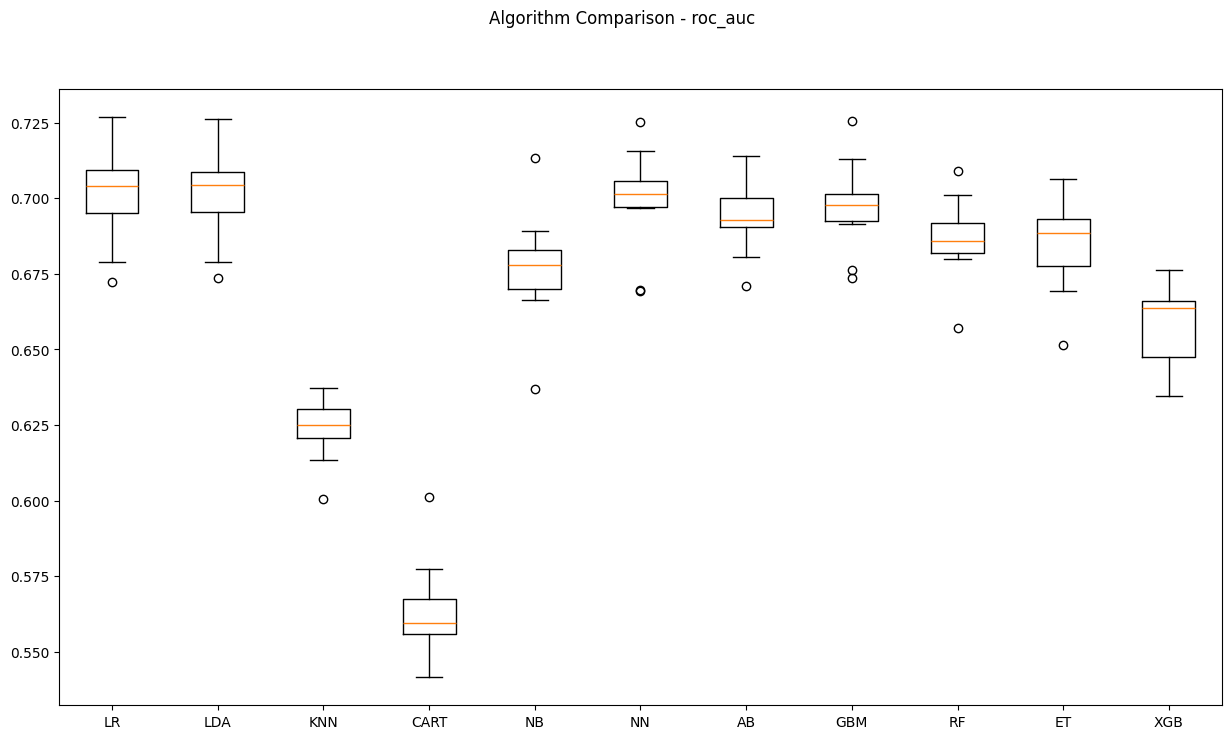

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison'+ ' - ' + scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()